In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tueplots import bundles
from tueplots.constants.color import rgb

In [9]:
gain_dict = {}
main_folder_path = '../dat/convergence'
for foldername in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, foldername)

    folder_dict = {}
    print(foldername)

    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            key_city = filename.split('_')[2].replace(".json", "")
            key_city = key_city.replace('ä', 'ae').replace('ö', 'oe').replace('ü', 'ue')

            df = pd.read_json(file_path, orient='index')
            df.index = df.index.str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue')
            folder_dict[key_city] = df
    
    gain_dict[foldername] = folder_dict

no_wait
theoretical_max_gain


In [10]:
dict_mean_delays = {}

for key_gain, df_dict in gain_dict.items():
    empty = pd.DataFrame(index=range(1, 181), columns=['mean_delay', 'reachable1', 'reachable2', 'reachable3'])
    empty.loc[:, ['reachable1', 'reachable2', 'reachable3']] = 0
    delay_matrix = [[] for _ in range(180)]

    for key, df in df_dict.items():

        for i in range(len(df)):
            row = df.iloc[i]
            valid_minutes = np.array(row['switch time']) <= 180
            minutes = np.array(row['switch time'])[valid_minutes].astype(int)
            delays = np.array(row['delay'])[valid_minutes]

            for minute, delay in zip(minutes, delays):
                delay_matrix[minute-1].append(delay)

            cases = np.array(row['reachable'])[valid_minutes]
            for case in [1, 2, 3]:
                empty.loc[minutes[cases == case], f'reachable{case}'] += 1

    means = [np.mean(minute).round(2) if minute else np.nan for minute in delay_matrix]
    empty['mean_delay'] = means
    df_mean_delays = empty

    dict_mean_delays[key_gain] = df_mean_delays



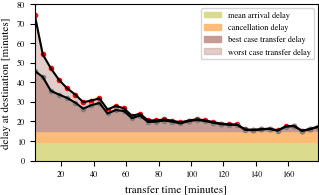

In [20]:
mean_train_delay = 9.462575828807317
max_transfer_time = 180
bucket_size = 5

plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update()
#plt.rcParams.update({'font.size': 15})

worst_case = np.array(dict_mean_delays['no_wait']["mean_delay"])
best_case = np.array(dict_mean_delays['theoretical_max_gain']["mean_delay"])

# create data buckets
data_array = np.array(worst_case)
buckets = data_array.reshape(max_transfer_time // bucket_size, bucket_size)
means = np.mean(buckets, axis=1)
worst_case = means

data_array = np.array(best_case)
buckets = data_array.reshape(max_transfer_time // bucket_size, bucket_size)
means = np.mean(buckets, axis=1)
best_case = means

x_data = np.arange(1 + bucket_size/2, max_transfer_time, bucket_size) 
y_data = best_case  

fig, ax = plt.subplots() #figsize=(8, 6)

# plot areas
ax.fill_between(x_data, 0, mean_train_delay, color="#DBDB8D", label='mean arrival delay')
ax.fill_between(x_data, mean_train_delay, np.min(best_case), color="#FFBB78", label='cancellation delay')
ax.fill_between(x_data, np.min(best_case), best_case, color="#C49C94", where=(best_case >= np.min(best_case)), label='best case transfer delay')
ax.fill_between(x_data, np.min(best_case), worst_case, color="#C49C94", alpha=0.5, where=(worst_case >= np.min(best_case)), label='worst case transfer delay')

# plot data
ax.scatter(x_data, worst_case, color="red", marker='.')
ax.scatter(x_data, best_case, color="grey", marker='.')
ax.plot(x_data, worst_case, color="black")
ax.plot(x_data, best_case, color="black")

# Set y and x limits
ax.set_ylim([0, 80])
ax.set_xlim([np.min(x_data), np.max(x_data)])

# Labels and legend
ax.set_xlabel('transfer time [minutes]')
ax.set_ylabel('delay at destination [minutes]')
ax.legend()

plt.savefig("plot_delay_decomposition.pdf", format="pdf")
plt.show()